# 데이터 불러오기

- use_log.csv 데이터와 저번 장에서 정의했던 customer_join.csv 데이터를 사용.

In [1]:
import numpy as np
import pandas as pd

uselog = pd.read_csv("use_log.csv")
customer = pd.read_csv("customer_join.csv")

In [2]:
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [3]:
customer.head()

,customer_id,gender,start_date,end_date,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_flg,membership_months
0,OA832399,F,2015-05-01,NaN,0,0_종일,10500,2_일반,4.833333,5.0,8,2,4,1,47
1,PL270116,M,2015-05-01,NaN,0,0_종일,10500,2_일반,5.083333,5.0,7,3,5,1,47
2,OA974876,M,2015-05-01,NaN,0,0_종일,10500,2_일반,4.583333,5.0,6,3,5,1,47
3,HD024127,F,2015-05-01,NaN,0,0_종일,10500,2_일반,4.833333,4.5,7,2,5,1,47
4,HD661448,F,2015-05-01,NaN,0,2_야간,6000,2_일반,3.916667,4.0,6,1,5,1,47


# 회원 그룹화 (클러스터링)
- customer 데이터를 바탕으로 K-Means Clustering 진행
- 이용 횟수와 관련한 변수들을 중심으로 클러스터링 할 것

In [4]:
# 클러스터링에 사용할 변수 지정
clustering = customer[["mean", "median", "max", "min", "membership_months"]]

# 칼럼 명 변경
clustering.columns = ["monthly_average", "monthly_median", "monthly_maximum", "monthly_minimum", "membership_months"]

clustering.head()

,monthly_average,monthly_median,monthly_maximum,monthly_minimum,membership_months
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


- 현재 각 칼럼 별 단위가 다르기 때문에 표준화 진행

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 표준화 진행 
scaler = StandardScaler()
clustering_standardized = scaler.fit_transform(clustering)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit(clustering_standardized)

# 클러스터링 결과 칼럼 추가
clustering["cluster"] = clusters.labels_

<ipython-input-5-b153968ca0dc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering["cluster"] = clusters.labels_


In [6]:
clustering.head(3)

,monthly_average,monthly_median,monthly_maximum,monthly_minimum,membership_months,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1


In [7]:
clustering.tail(3)

,monthly_average,monthly_median,monthly_maximum,monthly_minimum,membership_months,cluster
4189,8.0,8.0,8,8,1,0
4190,11.0,11.0,11,11,1,0
4191,10.0,10.0,10,10,1,0


In [8]:
clustering.cluster.value_counts()

1    1822
2    1244
0    1126
Name: cluster, dtype: int64

# 클러스터링 결과 분석

In [9]:
clustering.groupby("cluster").mean()

,monthly_average,monthly_median,monthly_maximum,monthly_minimum,membership_months
cluster,,,,,
0,7.675391,7.638988,9.904085,5.547069,8.681172
1,5.009250,5.007135,7.648738,2.395170,32.383095
2,3.687399,3.445338,6.197749,1.719453,8.185691


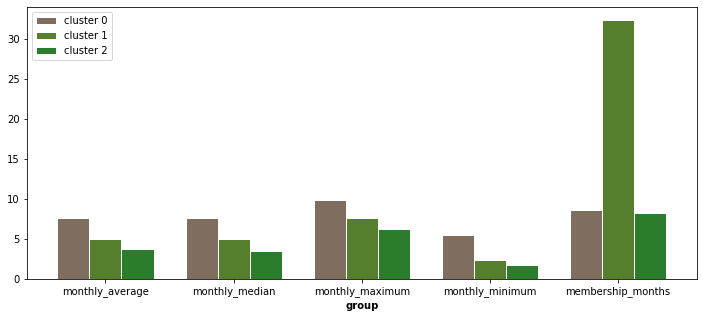

In [10]:
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(12,5))

# set width of bar
barWidth = 0.25

# set height of bar
bars_0 = clustering.groupby("cluster").mean().iloc[0]
bars_1 = clustering.groupby("cluster").mean().iloc[1]
bars_2 = clustering.groupby("cluster").mean().iloc[2]

# Set position of bar on X axis
r1 = np.arange(len(bars_0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars_0, color='#7f6d5f', width=barWidth, edgecolor='white', label='cluster 0')
plt.bar(r2, bars_1, color='#557f2d', width=barWidth, edgecolor='white', label='cluster 1')
plt.bar(r3, bars_2, color='#2b7c2b', width=barWidth, edgecolor='white', label='cluster 2')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars_0))], clustering.groupby("cluster").mean().columns)

# Create legend & Show graphic
plt.legend()
plt.show()

- 그룹 0: 이용기간이 짧지만 이용률이 높음
- 그룹 1: 장기 회원들
- 그룹 2: 이용률과 이용기간이 둘 다 낮음

# 클러스터링 결과 시각화

- 시각화를 위해 주성분분석을 이용해 차원축소

In [11]:
from sklearn.decomposition import PCA

# 주성분 두개로 차원축소
x = clustering_standardized
pca = PCA(n_components=2, random_state=0)  
x_pca = pca.fit_transform(x)

pca.explained_variance_ratio_.sum()  # 두개의 주성분의 설명력

0.8798019226140579

In [12]:
# 주성분 적재행렬 계산
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=clustering.columns[:5])
loading_matrix

,PC1,PC2
monthly_average,0.989778,-0.106778
monthly_median,0.954834,-0.145198
monthly_maximum,0.821017,-0.230398
monthly_minimum,0.873386,0.124402
membership_months,-0.353154,-0.919815


- PC1: 월별 이용 횟수
- PC2: 회원 기간 (반비례)

In [13]:
# 주성분 축으로 변환된 벡터행렬
pca_df = pd.DataFrame(x_pca)
pca_df.columns = ["PC1", "PC2"]
pca_df["cluster"] = clustering.cluster   # 앞서 진행한 클러스터링 결과 추가

pca_df.head()

,PC1,PC2,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1


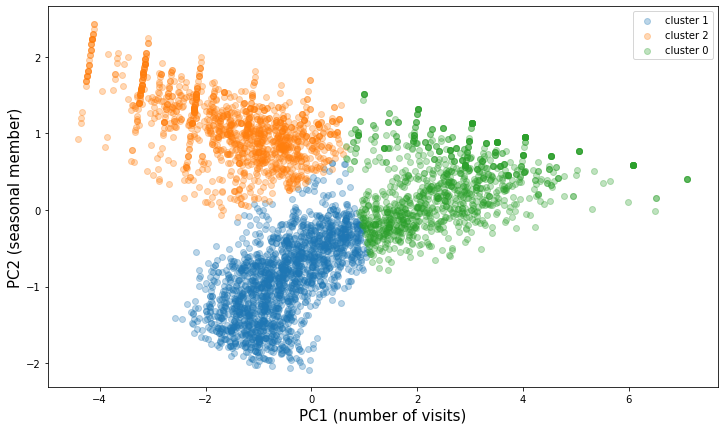

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.axis()
plt.xlabel("PC1 (number of visits)", fontsize=15)
plt.ylabel("PC2 (seasonal member)", fontsize=15)

for i in clustering.cluster.unique():
    filter1 = (pca_df.cluster == i)
    PC1 = pca_df[filter1]["PC1"]
    PC2 = pca_df[filter1]["PC2"]
    plt.scatter(PC1, PC2, alpha=0.3, label="cluster {}".format(i))
    
plt.legend() # 범례 추가

plt.show()

# 회원들의 경향성 파악
- 클러스터링 결과를 바탕으로 지속 회원과 탈퇴 회원을 파악해보자.

In [15]:
# 그룹 별 탈퇴 회원 수 파악
df = pd.concat([clustering, customer], axis=1)
df.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,1055
1,0,1,71
2,1,0,1784
3,1,1,38
4,2,0,3
5,2,1,1241


- 그룹 2에서 탈퇴 회원이 매우 많음
- 그룹 2: 초반에 의욕이 넘쳐서 등록했다가 탈주하는 듯

In [16]:
# 그룹 별 정기 이용 여부 파악
df.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,86
1,0,1,1040
2,1,0,5
3,1,1,1817
4,2,0,688
5,2,1,556


- 다른 그룹에 비해서 비정기적 이용 회원이 그룹2에서 압도적으로 많음.

# 고객의 이용 횟수 예측

- 과거 6개월의 데이터를 사용해 다음 달의 이용 횟수를 예측해보자.
- 예측 모형에는 랜덤포레스트를 사용한다.

## 예측에 사용할 데이터 정의

In [17]:
# 날짜 자료형 변환
uselog.usedate = pd.to_datetime(uselog.usedate)

# 연월 칼럼 추가 
uselog["y/m"] = uselog.usedate.dt.strftime("%Y%m")

# 월별 방문횟수를 집계하는데 임시적으로 사용될 데이터 프레임 정의
uselog_months = uselog.groupby(["customer_id", "y/m"], as_index=False).count()
uselog_months.rename(columns={"log_id": "num_visits"}, inplace=True)
uselog_months.drop("usedate", axis=1, inplace=True)

In [18]:
uselog_months.head()

,customer_id,y/m,num_visits
0,AS002855,201804,4
1,AS002855,201805,5
2,AS002855,201806,5
3,AS002855,201807,5
4,AS002855,201808,3


In [19]:
year_months = uselog_months["y/m"].unique()
predict_data = pd.DataFrame()

for i in range(6, len(year_months)):
    filter1 = (uselog_months["y/m"] == year_months[i])
    tmp = uselog_months[filter1]
    tmp.rename(columns={"num_visits": "count_pred"}, inplace=True)
    
    for j in range(1, 7):
        filter2 = (uselog_months["y/m"] == year_months[i - j])
        tmp_before = uselog_months[filter2]
        tmp_before.drop("y/m", axis=1, inplace=True)
        tmp_before.rename(columns = {"num_visits": "lag_{}".format(j)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
        
    predict_data = pd.concat([predict_data, tmp])

/Users/dongwook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/dongwook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
predict_data.dropna(inplace=True)
predict_data = predict_data.reset_index(drop=True)

predict_data

,customer_id,y/m,count_pred,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,AS002855,201810,3,7.0,3.0,5.0,5.0,5.0,4.0
1,AS009373,201810,5,6.0,6.0,7.0,4.0,4.0,3.0
2,AS015315,201810,4,7.0,3.0,6.0,3.0,3.0,6.0
3,AS015739,201810,5,6.0,5.0,8.0,6.0,5.0,7.0
4,AS019860,201810,7,5.0,7.0,4.0,6.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
15108,TS995299,201903,3,3.0,5.0,4.0,5.0,4.0,5.0
15109,TS998593,201903,8,7.0,8.0,7.0,9.0,9.0,9.0
15110,TS999079,201903,3,2.0,6.0,9.0,6.0,6.0,4.0
15111,TS999231,201903,6,6.0,3.0,8.0,5.0,5.0,4.0


## 특징 변수 추가

- 사용할 데이터가 시계열 자료이기 때문에 회원 기간을 추가.

In [21]:
# 회원 가입일 칼럼 추가
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,customer_id,y/m,count_pred,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,start_date
0,AS002855,201810,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,AS009373,201810,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,AS015315,201810,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,AS015739,201810,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,AS019860,201810,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [22]:
# 현재 날짜를 나타내는 칼럼 생성
predict_data["now_date"] = pd.to_datetime(predict_data["y/m"], format="%Y%m")

# start_date 칼럼 자료형 변환
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

In [23]:
from dateutil.relativedelta import relativedelta

predict_data["period"] = None

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years * 12 + delta.months


<ipython-input-23-abd0542c50d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years * 12 + delta.months


In [24]:
predict_data

,customer_id,y/m,count_pred,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,start_date,now_date,period
0,AS002855,201810,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,AS009373,201810,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,AS015315,201810,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,AS015739,201810,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,AS019860,201810,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12
...,...,...,...,...,...,...,...,...,...,...,...,...
15108,TS995299,201903,3,3.0,5.0,4.0,5.0,4.0,5.0,2015-09-01,2019-03-01,42
15109,TS998593,201903,8,7.0,8.0,7.0,9.0,9.0,9.0,2018-09-01,2019-03-01,6
15110,TS999079,201903,3,2.0,6.0,9.0,6.0,6.0,4.0,2016-06-01,2019-03-01,33
15111,TS999231,201903,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01,2019-03-01,24


## 모델링

- 예측에는 랜덤포레스트 모델을 사용한다.
- 현재 데이터의 개수가 비교적 작고, 독립변수들이 독립성이 보장되지 않는 시계열 데이터이기에 좀 더 robust 한 모델인 트리 모델을 사용하는 것이 바람직하다고 판단했다.

In [25]:
# 2018년 4월 이후에 새로 가입한 회원들의 데이터만 사용
predict_data = predict_data[predict_data.start_date >= pd.to_datetime("20180401")]

In [26]:
from sklearn.model_selection import train_test_split

X = predict_data[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "period"]]
y = predict_data["count_pred"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [27]:
# 랜덤포레스트 모델의 최적 하이퍼파라미터 찾아주기
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

hyper_params = {'n_estimators': [50, 100, 150, 200],
                'min_samples_split': [2, 3, 4, 5]} #hyperparameter를 dict type으로 넣기

GridCV = GridSearchCV(estimator=rf, param_grid=hyper_params, cv=5, verbose=1, n_jobs=-1)
GridCV.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.0s finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [28]:
GridCV.best_params_

{'min_samples_split': 5, 'n_estimators': 200}

In [29]:
# 위에서 구한 최적의 하이퍼 파라미터 적용
rf = RandomForestRegressor(**GridCV.best_params_, n_jobs=-1)

# 학습 데이터 피팅
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=200, n_jobs=-1)

In [30]:
# MSE
from sklearn.metrics import mean_squared_error
predictions = rf.predict(X_test)
mean_squared_error(y_test, predictions)

2.6254575249050913

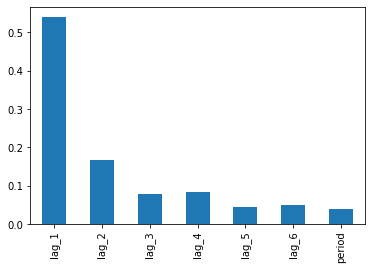

In [31]:
# 변수중요도
pd.Series(rf.feature_importances_, index=X.columns).plot(kind="bar")
plt.show()

## 예측

In [32]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [8, 7, 9, 4, 8, 6, 7]
x_pred = [x1, x2]

print("회원 1은 다음 달에 {:.2f}번 방문할 것으로 예상됩니다.".format(rf.predict(x_pred)[0]))
print("회원 2는 다음 달에 {:.2f}번 방문할 것으로 예상됩니다.".format(rf.predict(x_pred)[1]))

회원 1은 다음 달에 3.01번 방문할 것으로 예상됩니다.
회원 2는 다음 달에 6.78번 방문할 것으로 예상됩니다.


# 데이터 기록

In [33]:
uselog_months.to_csv("uselog_months.csv", index=False)